In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import any_null_col, add_coordinates
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GroupKFold



pd.options.display.max_columns = 999
random_state = 39

In [292]:
n = 90000
df = pd.read_csv('../../CSGO/mm_master_demos.csv')[:n]
# df = df.sample(frac=0.1, random_state=random_state)
df = df.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df = df[df['att_rank'] != 0]
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,False,NaN,Head,USP,Pistol,300,Team 1,CounterTerrorist,76561198085893650,17,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
1,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,25,0,False,NaN,RightLeg,USP,Pistol,300,Team 1,CounterTerrorist,76561198223006752,16,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
2,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,20,0,False,NaN,LeftLeg,Glock,Pistol,300,Team 1,CounterTerrorist,76561198051040004,17,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
3,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,17,8,False,NaN,Chest,USP,Pistol,300,Team 1,CounterTerrorist,76561198223006752,16,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
4,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,12,7,False,NaN,Chest,Glock,Pistol,300,Team 1,CounterTerrorist,76561198051040004,17,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0


In [293]:
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,False,NaN,Head,USP,Pistol,300,Team 1,CounterTerrorist,76561198085893650,17,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
1,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,25,0,False,NaN,RightLeg,USP,Pistol,300,Team 1,CounterTerrorist,76561198223006752,16,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
2,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,20,0,False,NaN,LeftLeg,Glock,Pistol,300,Team 1,CounterTerrorist,76561198051040004,17,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
3,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,17,8,False,NaN,Chest,USP,Pistol,300,Team 1,CounterTerrorist,76561198223006752,16,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
4,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,12,7,False,NaN,Chest,Glock,Pistol,300,Team 1,CounterTerrorist,76561198051040004,17,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0


In [294]:
### Checks if df has null values
if_null = any_null_col(df)

Columns containing null values: ['bomb_site'] with null ratios: [0.849]


In [295]:
### many rows have null values for 'bomb_site' because is the bomb is not planted, i.e. is_bomb_planted = False, there is no bomb_site
# verification:
np.mean(df['is_bomb_planted'] == False) == np.mean(df['bomb_site'].isnull())

True

#### Target Variable: att_rank
- att_rank is an ordinal variable indicating players' ranks from 1 to 18
- att_rank = 0 is dropped from dataframe since we are only interested in players who has a rank
- att_rank: the rank for the attacker

There is only 0.044% of players at rank 1, i.e. only 39 out of 88202 players.


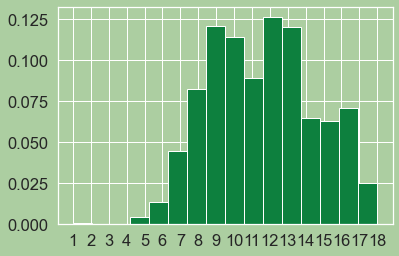

In [296]:
### target variable
# distribution
# it is difficult to get very good, yet it's also very hard to stay very bad 
target = 'att_rank'
df[target].hist(bins=df[target].nunique()-1, density=True, color='#0d803e')
plt.xticks(range(1, 19))
rank_1_n = np.sum(df[target] == 1)
rank_1_percent = np.round(np.mean(df[target] == 1) * 100, 3)
sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=1.5)
sns.set_color_codes(palette='muted')


print('There is only {}% of players at rank 1, i.e. only {} out of {} players.'.format(rank_1_percent, rank_1_n, df.shape[0]))

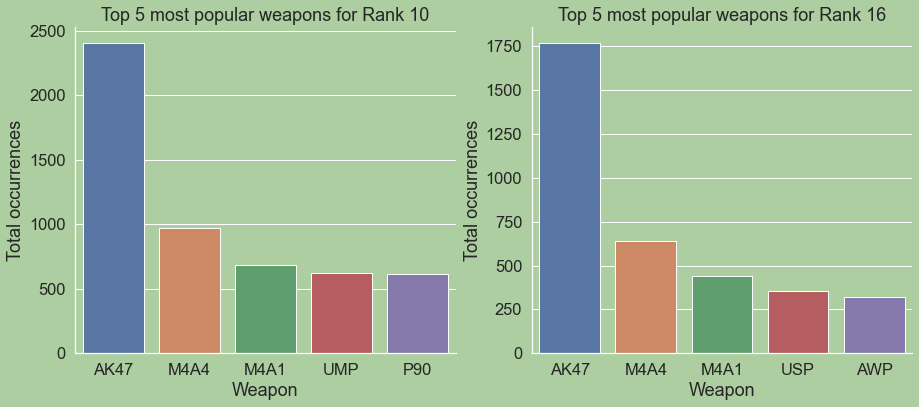

In [297]:
wp_ranks = [10, 16]
n_top_wp = 5
fig, ax = plt.subplots(1, len(wp_ranks), figsize=(15, 6))
for i in range(len(wp_ranks)):
    top_5_weaps = df[df['att_rank'] == wp_ranks[i]]['wp'].value_counts().head(n_top_wp)

    sns.barplot(ax=ax[i], x=top_5_weaps.index, y=top_5_weaps.values)
    ax[i].set_xlabel('Weapon')
    ax[i].set_ylabel('Total occurrences')
    ax[i].set_title('Top {} most popular weapons for Rank {}'.format(n_top_wp, wp_ranks[i]))


sns.despine()



/Users/haibo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/haibo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


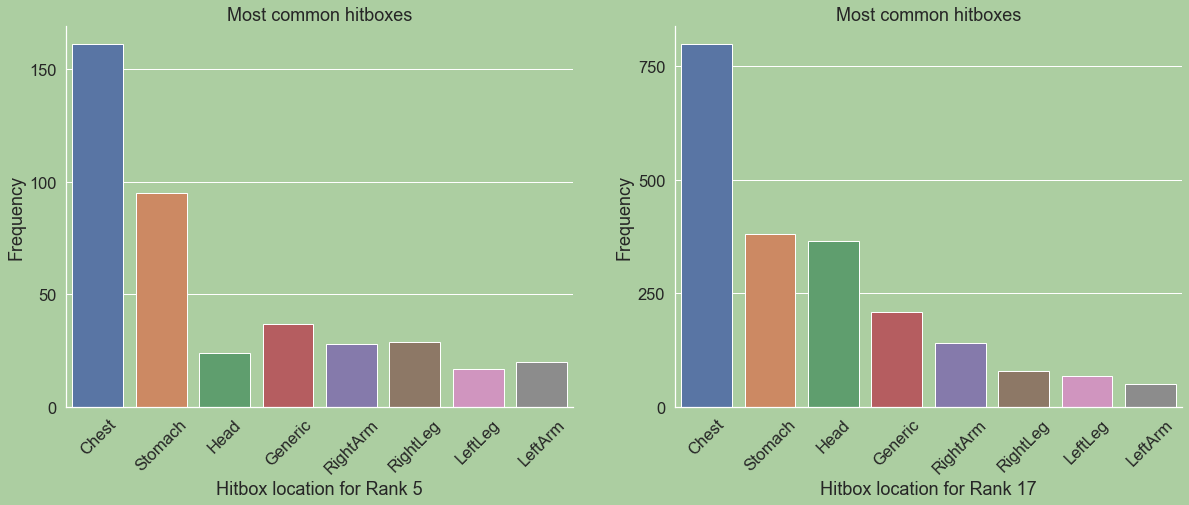

In [298]:
hit_box_ranks = [5, 17]
fig, ax = plt.subplots(1, len(hit_box_ranks), figsize=(20, 7))

# sns.set(font_scale=10)


for i in range(len(hit_box_ranks)):
    
    g = sns.countplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i], order=df['hitbox'].value_counts().index)
    # g = sns.histplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i], stat='density')

    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    ax[i].set_xlabel('Hitbox location for Rank {}'.format(hit_box_ranks[i]))
    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Most common hitboxes')
sns.despine()

sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4)
sns.set_color_codes(palette='muted')




## TODO: hitbox for different weapons!!!!

In [299]:
map_data = pd.read_csv('../../CSGO/map_data.csv', index_col=0)
map_data.loc['de_overpass'] = {'StartX': -4820, 'StartY': -3591, 'EndX': 503, 'EndY': 1740, 'ResX': 1024, 'ResY': 1024}
map_data.loc['de_nuke'] = {'StartX': -3082, 'StartY': -4464, 'EndX': 3516, 'EndY': 2180, 'ResX': 1024, 'ResY': 1024}
df_ = pd.read_csv('../../CSGO/mm_master_demos.csv')
df_ = df_.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df_ = df_[df_['att_rank'] != 0]

add_coordinates(df_, map_data)

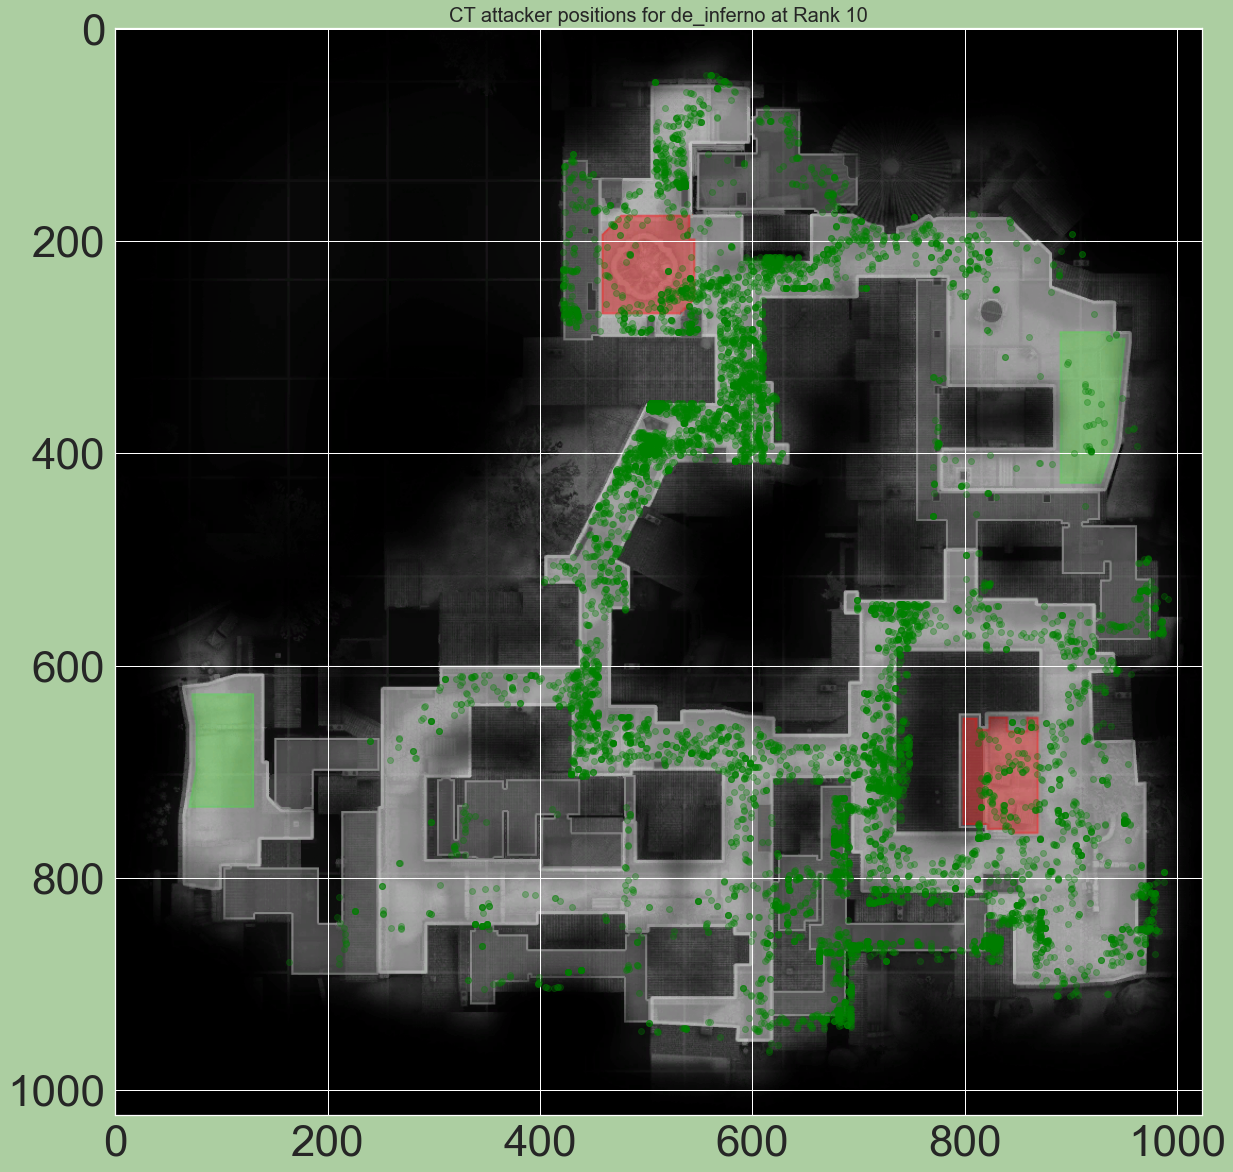

In [300]:
map_name = 'de_inferno'
map_rank = 10
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread(f'../images/{map_name}.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.3, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
# sns.set_style("whitegrid", {'axes.grid' : False})

sns.set_color_codes(palette='muted')
sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4, style='white')

plt.show()

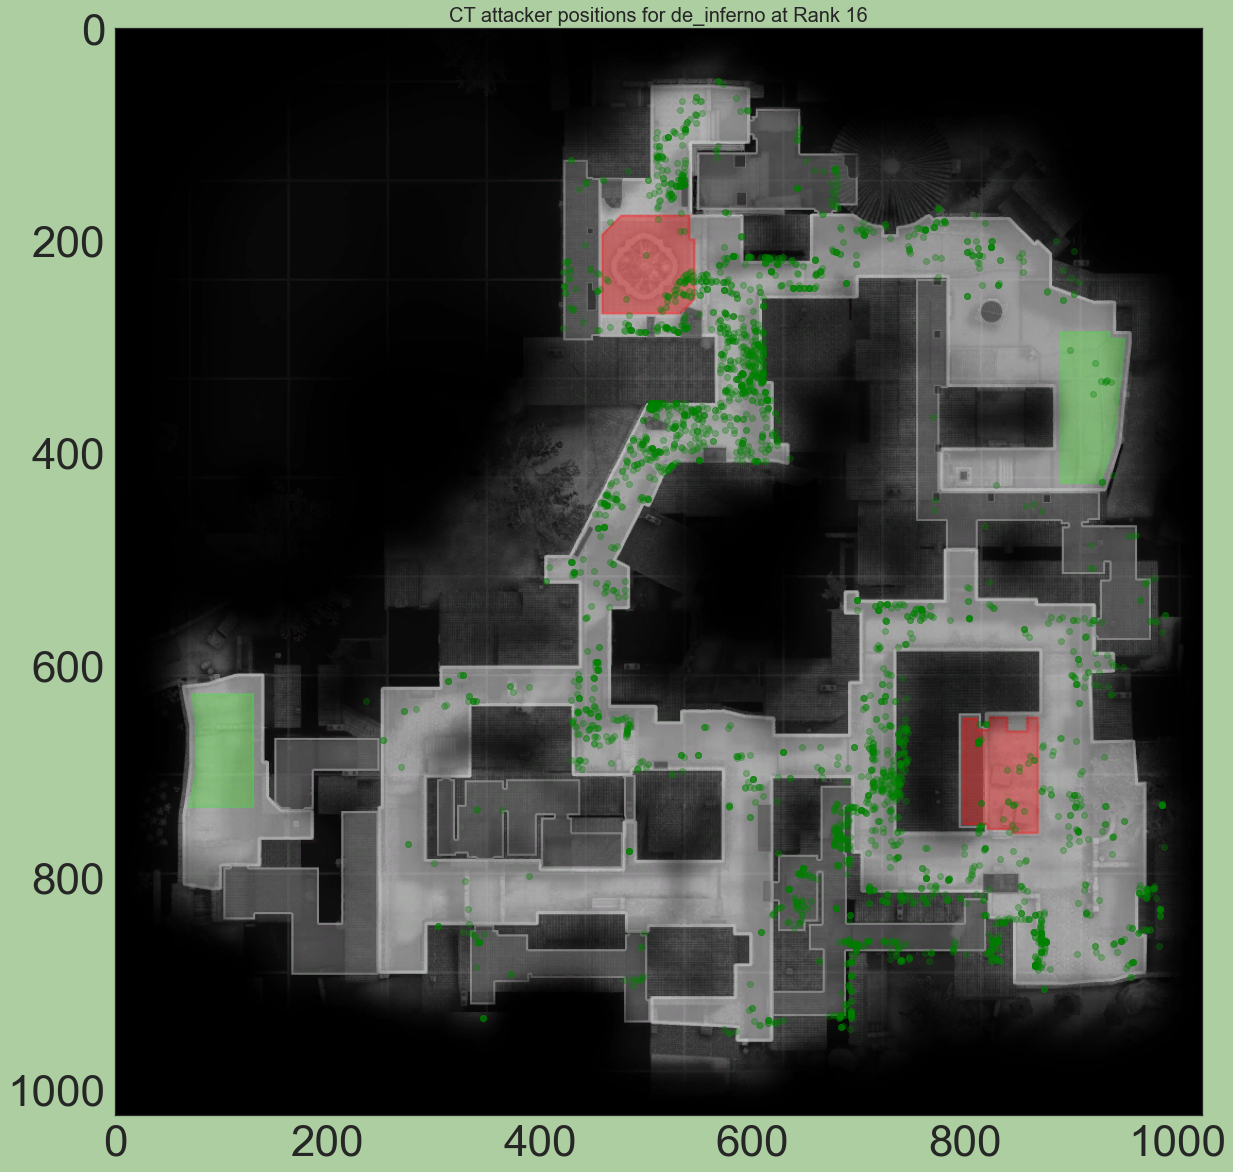

In [301]:
map_name = 'de_inferno'
map_rank = 16
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread(f'../images/{map_name}.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.3, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
sns.set_color_codes(palette='muted')
sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4, style='white')
plt.show()

In [303]:
to_drop = ['date', 'att_team', 'round', 'tick', 'vic_team', 'vic_side', 'bomb_site', 'award', 'winner_team', 'winner_side', 'vic_id', 'avg_match_rank']
dmg = df.drop(to_drop, axis=1)
dmg.head()

,map,seconds,att_side,hp_dmg,arm_dmg,is_bomb_planted,hitbox,wp,wp_type,att_id,att_rank,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val
0,de_dust2,133.0582,CounterTerrorist,100,0,False,Head,USP,Pistol,76561198085893650,17,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850
1,de_dust2,134.9023,CounterTerrorist,25,0,False,RightLeg,USP,Pistol,76561198223006752,16,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850
2,de_dust2,135.0586,Terrorist,20,0,False,LeftLeg,Glock,Pistol,76561198051040004,17,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850
3,de_dust2,135.2774,CounterTerrorist,17,8,False,Chest,USP,Pistol,76561198223006752,16,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850
4,de_dust2,135.4024,Terrorist,12,7,False,Chest,Glock,Pistol,76561198051040004,17,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850


In [305]:

ordinal_ftrs = ['vic_rank']
ordinal_cats = list(range(1, 19))
onehot_ftrs = ['map', 'att_side', 'is_bomb_planted', 'hitbox', 'we_type', 'round_type', 'wp']
minmax_ftrs = ['seconds', 'hp_dmg', 'arm_dmg']
std_ftrs = ['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'ct_eq_val', 't_eq_val']

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
X = dmg.drop(['att_rank', 'att_id'], axis=1)
y = dmg['att_rank']
groups = X['att_id']
group_kfold = GroupKFold()

for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]